# Imports

In [2]:
using CSV
using DataFrames
using Statistics
using Dates
using Random
using Plots
using StatsPlots
using StatsBase

# Cleaning the data

## Eliminating double comas ",," after wrong column
Changing them to ","

In [3]:
# Preparar paths
path = "dataSets/damCombustible.csv"
cleaned_path = "dataSets/damCombustible_cleaned.csv"

# Corregir cada linea del CSV
function fix_csv_line(line::String)
    parts = split(line, ",")
    horometro_index = 3
    
    if length(parts) > horometro_index + 1 && !isempty(parts[horometro_index + 1])
        while length(parts) > horometro_index + 2 && parts[horometro_index + 2] == ""
            parts = vcat(parts[1:horometro_index + 1], parts[horometro_index + 3:end])
        end
    end

    return join(parts, ",")
end
        

function correct_csv_file(input_path::String, output_path::String)
    csv_lines = readlines(input_path)

    fixed_lines = [fix_csv_line(line) for line in csv_lines]

    open(output_path, "w") do file
        for line in fixed_lines
            println(file, line)
        end
    end
end

correct_csv_file(path, cleaned_path)

df = CSV.read(cleaned_path, DataFrame)
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Nro.,320.709,2,322.5,638,0,Int64
2,Vehículo,105.566,101,105.0,110,0,Int64
3,Odómetro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Horómetro,40.0,4,33.0,86,618,"Union{Missing, Int64}"
5,Fecha,,01/abr./2024 12:39:00,,31/may./2024 1:54:00,0,String31
6,Tanqueo Full,,N,,S,0,String1
7,Costo por Volumen,,"23,24",,"26,97",0,String7
8,Cant.,,100,,"99,13",0,String7
9,Unidad,,Litros,,Litros,0,String7


## Changing columns data-type to correct data-type
Fecha = DateTime

Tanqueo Full = Int 0 - 1

Costo por Volumen = Float32

Cantidad = Float32

Costo Total = Float32

In [4]:
propertynames(df)

12-element Vector{Symbol}:
 Symbol("Nro.")
 :Vehículo
 :Odómetro
 :Horómetro
 :Fecha
 Symbol("Tanqueo Full")
 Symbol("Costo por Volumen")
 Symbol("Cant.")
 :Unidad
 Symbol("Costo Total")
 :Tipo
 :Column12

In [5]:
# Rename columns
rename!(df, Symbol("Nro.") => :Numero,
    :Vehículo => :Vehiculo, :Odómetro => :Odometro,
    :Horómetro => :Horometro,
    Symbol("Tanqueo Full") => :Tanque_Lleno,
    Symbol("Costo por Volumen") => :Costo_Por_Volumen,
    Symbol("Cant.") => :Cantidad,
    Symbol("Costo Total") => :Costo_Total)

# Drop useless Columns
select!(df, Not(:Column12, :Horometro, :Unidad, :Tipo))

propertynames(df)

8-element Vector{Symbol}:
 :Numero
 :Vehiculo
 :Odometro
 :Fecha
 :Tanque_Lleno
 :Costo_Por_Volumen
 :Cantidad
 :Costo_Total

In [6]:
df

Row,Numero,Vehiculo,Odometro,Fecha,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Int64,String31,String1,String7,String7,String7
1,634,101,1086986,06/ago./2024 17:33:18,S,"24,95",20,499
2,633,101,1086986,06/ago./2024 17:29:56,S,"25,38",394,9999
3,637,102,1023146,06/ago./2024 6:23:00,S,"24,57",127,3120
4,638,110,595357,06/ago./2024 3:51:00,S,"25,51",196,5000
5,636,105,492843,05/ago./2024 23:00:00,S,"24,57",127,3120
6,635,107,1106110,05/ago./2024 16:06:00,S,"24,79",115,2851
7,609,102,1022660,04/ago./2024 5:33:00,S,"25,8",141,3638
8,622,107,1105674,04/ago./2024 1:13:00,S,"25,86",124,3207
9,621,107,1105284,03/ago./2024 18:20:53,S,"25,69",111,2852


In [7]:
# Convert S and N to 1 and 0 respectively
# df.Tanque_Lleno = df.Tanque_Lleno .== "S"
transform!(df, :Tanque_Lleno => ByRow(x -> x == "S" ? 1 : 0) => :Tanque_Lleno)

#---------------------------------------------------------------

# Date convertion 
# Change spanish name to english
function replaceMonths(date)
    months = Dict(
        "ene." => "01", "feb." => "02", "mar." => "03", "abr." => "04",
        "may." => "05", "jun." => "06", "jul." => "07", "ago." => "08",
        "sep." => "09", "oct." => "10", "nov." => "11", "dic." => "12"
    )

    for (mes, month) in months
        if occursin(mes, date)
            return replace(date, mes => month)
        end
    end

    return date
end

df.Fecha = replaceMonths.(df.Fecha)

df.Fecha = Dates.DateTime.(df.Fecha, "dd/mm/yyyy HH:MM:SS")

#---------------------------------------------------------------

# Columns to convert with commas
columns_with_commas_to_convert = [:Costo_Por_Volumen, :Cantidad, :Costo_Total]

# Replace columns with dots and to float
for col in columns_with_commas_to_convert
    df[!, col] = replace.(df[!, col], "," => ".")
    df[!, col] = parse.(Float32, df[!, col])
end

In [8]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Numero,320.709,2,322.5,638,0,Int64
2,Vehiculo,105.566,101,105.0,110,0,Int64
3,Odometro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Fecha,,2024-04-01T12:39:00,2024-05-31T16:37:16,2024-08-06T17:33:18,0,DateTime
5,Tanque_Lleno,0.800633,0,1.0,1,0,Int64
6,Costo_Por_Volumen,25.2959,23.24,25.29,26.97,0,Float32
7,Cantidad,160.645,13.0,120.025,665.0,0,Float32
8,Costo_Total,4058.61,329.0,3055.5,16353.0,0,Float32


In [9]:
size(df)

(632, 8)

# Suffle Data

In [10]:
# Firts we drop Fecha and Numero columns
df = select(df, Not(:Numero, :Fecha))

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Int64,Float32,Float32,Float32
1,101,1086986,1,24.95,20.0,499.0
2,101,1086986,1,25.38,394.0,9999.0
3,102,1023146,1,24.57,127.0,3120.0
4,110,595357,1,25.51,196.0,5000.0
5,105,492843,1,24.57,127.0,3120.0
6,107,1106110,1,24.79,115.0,2851.0
7,102,1022660,1,25.8,141.0,3638.0
8,107,1105674,1,25.86,124.0,3207.0
9,107,1105284,1,25.69,111.0,2852.0


In [11]:
# Mezclar los índices aleatoriamente
shuffled_df = df[shuffle(1:nrow(df)), :]

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Int64,Float32,Float32,Float32
1,107,1102316,1,26.97,79.0,2131.0
2,104,1019675,1,24.59,160.0,3934.0
3,108,1141914,1,26.67,120.0,3200.0
4,109,552009,1,24.59,665.0,16353.0
5,110,593136,1,26.01,145.0,3771.0
6,102,1004312,1,25.22,46.0,1160.0
7,101,1065017,1,24.99,400.0,9996.0
8,110,581999,0,25.23,396.0,9990.0
9,101,1076619,1,25.2,25.0,630.0


# Scaling

In [12]:
# Function to normalize data
function normalize(column)
    min_val = minimum(column)
    max_val = maximum(column)
    return (column .- min_val) ./ (max_val .- min_val)
end

# Function to standardize data (Non-used, no normal distribution. No mean = 0 and std = 1)
function standardize(column)
    mean_val = mean(column)
    std_val = std(column)
    return (column .- mean_val) ./ std_val
end

# Funciton to normalize VECTORS
function normalize_vector(vector)
    min_val = minimum(vector)
    max_val = maximum(vector)
    return (vector .- min_val) ./ (max_val .- min_val)
end

transform!(shuffled_df, :Odometro => normalize => :Odometro_Norm,
    :Costo_Por_Volumen => normalize => :Costo_Por_Volumen_Norm, 
    :Cantidad => normalize => :Cantidad_Norm,
    :Costo_Total => normalize => :Costo_Total_Norm)

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total,Odometro_Norm,Costo_Por_Volumen_Norm,Cantidad_Norm,Costo_Total_Norm
,Int64,Int64,Int64,Float32,Float32,Float32,Float64,Float32,Float32,Float32
1,107,1102316,1,26.97,79.0,2131.0,0.942796,1.0,0.101227,0.112456
2,104,1019675,1,24.59,160.0,3934.0,0.825754,0.36193,0.22546,0.224975
3,108,1141914,1,26.67,120.0,3200.0,0.998877,0.919571,0.16411,0.179169
4,109,552009,1,24.59,665.0,16353.0,0.163416,0.36193,1.0,1.0
5,110,593136,1,26.01,145.0,3771.0,0.221662,0.742628,0.202454,0.214803
6,102,1004312,1,25.22,46.0,1160.0,0.803996,0.530831,0.0506135,0.0518597
7,101,1065017,1,24.99,400.0,9996.0,0.88997,0.469169,0.593558,0.603283
8,110,581999,0,25.23,396.0,9990.0,0.205889,0.533512,0.587423,0.602908
9,101,1076619,1,25.2,25.0,630.0,0.906402,0.525469,0.0184049,0.0187843


# Ploting

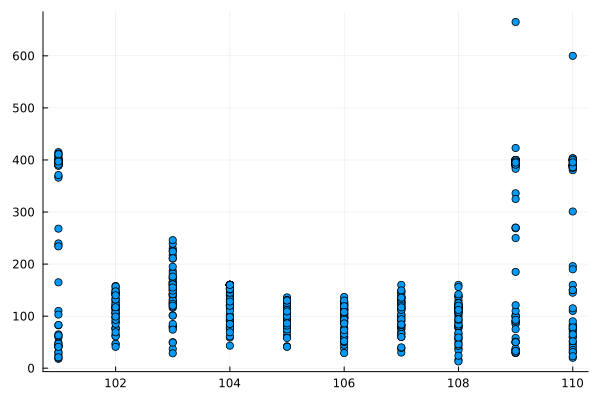

In [13]:
plot(shuffled_df.Vehiculo, shuffled_df.Cantidad, seriestype = :scatter, legend = false)

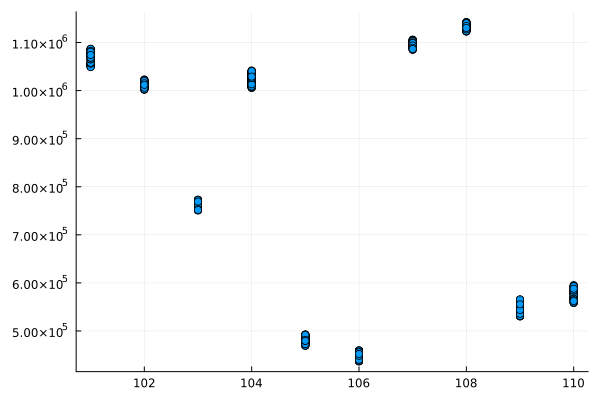

In [14]:
plot(shuffled_df.Vehiculo, shuffled_df.Odometro, seriestype = :scatter, legend = false)

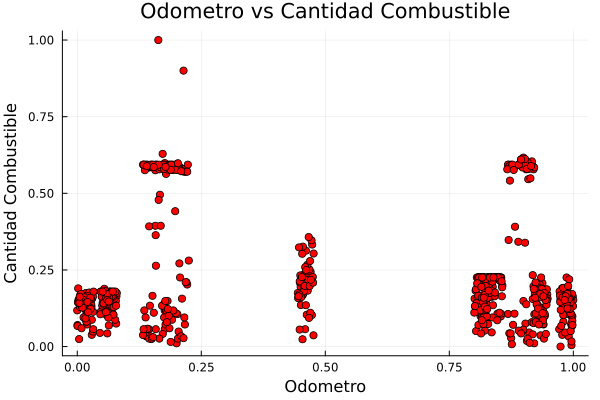

In [15]:
scatter(shuffled_df.Odometro_Norm, shuffled_df.Cantidad_Norm, title="Odometro vs Cantidad Combustible", xlabel="Odometro", ylabel="Cantidad Combustible", legend=false, color="red")

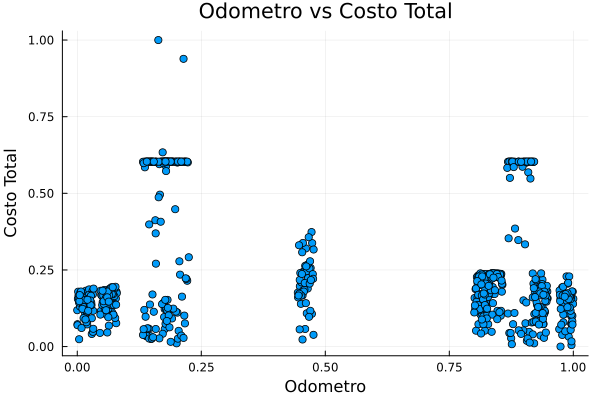

In [16]:
scatter(shuffled_df.Odometro_Norm,shuffled_df.Costo_Total_Norm, title="Odometro vs Costo Total", xlabel="Odometro", ylabel="Costo Total", legend=false)

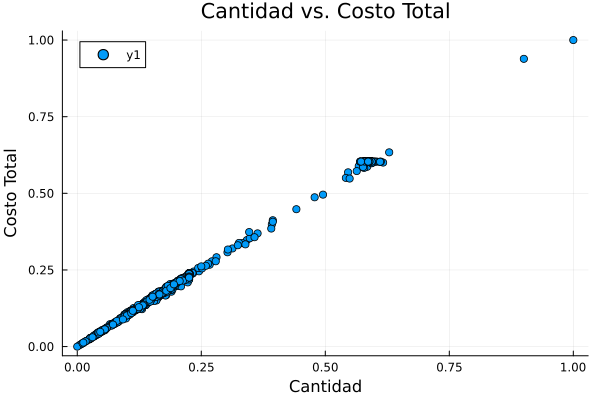

In [17]:
scatter(shuffled_df.Cantidad_Norm, shuffled_df.Costo_Total_Norm, title="Cantidad vs. Costo Total", xlabel="Cantidad", ylabel="Costo Total")

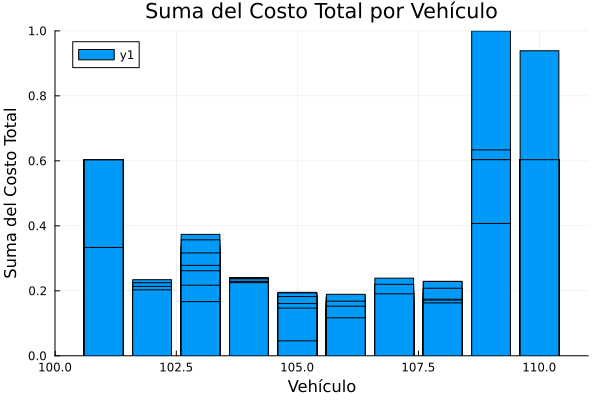

In [18]:
bar(shuffled_df.Vehiculo, shuffled_df.Costo_Total_Norm, title="Suma del Costo Total por Vehículo", xlabel="Vehículo", ylabel="Suma del Costo Total")

# Función de clasificación
Predeciremos la unidad con la

Cantidad

El Odometro

## Preparamos el df para todo el trabajo

In [19]:
# creamod un hyp_df con las columnas a usar
# Vehiculo
# Odometro_Norm
# Cantidad_Norm
hyp_df = select(shuffled_df, [:Odometro_Norm, :Cantidad_Norm])

# Creo un df aplicando One Hot Encoding para poder separar los vehiculos y entrenar varios modelos
trucks = 101:110

y = DataFrame([Symbol("Vehiculo_$(truck)") => (shuffled_df.Vehiculo .== truck) .|> Int for truck in trucks])
y

Row,Vehiculo_101,Vehiculo_102,Vehiculo_103,Vehiculo_104,Vehiculo_105,Vehiculo_106,Vehiculo_107,Vehiculo_108,Vehiculo_109,Vehiculo_110
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1
9,1,0,0,0,0,0,0,0,0,0


## Hipótesis

In [20]:
# Declaramos la funcion de hipotesis que va a correr todo para la unica neurona
function hyp(bias::Float64, hyp_df::DataFrame, i::Int64)
    global w
    y = 0.0
    # y = w1*x1 + w2*x2
    y = hyp_df.Odometro_Norm[i]*w[1] + hyp_df.Cantidad_Norm[i]*w[2]
    
    # Sumamos el bias
    y += bias

    # Funcion sigmoide
    y = 1/(1 + ℯ^(-y))

    # retornamos el resultado de la fila
    return y
 
end

hyp (generic function with 1 method)

## Imprimir todo

In [21]:
# Funcion para imprimir
function printInfo(epochs::Int64)

    global errors
    global w

    println("Epoch: ", epochs)
    println("Theta: ", w)
    println("Error: ", errors[epochs])
end

printInfo (generic function with 1 method)

## Funcion de obtencion de ajuste por w

In [22]:
# Funcion para calcular el ajuste de cada w
function adjustNumberCalculation(y::Vector{Int64}, row::Int64, hyp::Float64, hyp_df::DataFrame, wIndex::Int64)

    w_adjustment = -1*(y[row] * hyp) * hyp * (1 - hyp) * hyp_df[row, wIndex]

end

adjustNumberCalculation (generic function with 1 method)

## Funcion Gradiente Descendiente

In [22]:
# Declaramos el vector para guardar el historial de errores
global errors = Vector{Float64}()

function GD(epochs::Int64, alpha::Float64, hyp_df::DataFrame, y::Vector{Int64})
    global w
    global bias
    global errors
    
    temp_error_of_epoch = 0.0

    for row in 1:nrow(hyp_df)

        # Sacamos la hipostesis de la row
        hyp_result = hyp(bias, hyp_df, row)

        # Sacamos el error de la hyp
        hyp_error = hyp_result - y[row]
        temp_error_of_epoch += hyp_error

        # Calculamos error de la row y ajustamos w
        for w_index in 1:length(w)
            # Sacamos el error de la row con respecto a w
            adjust_number = adjustNumberCalculation(y, row, hyp_result, hyp_df, w_index)
            w[w_index] = w[w_index] - alpha * adjust_number
        end

    end



    # Sacamos el error promedio del epoch y lo guardamos en el historial de errores
    epoch_mean_error = temp_error_of_epoch/nrow(hyp_df)
    push!(errors, epoch_mean_error)

end

GD (generic function with 1 method)

## Separating Data - Train - Test

### Cambiar model al modelo a entrenar, del 1 al 10 (Cambiar aqui el modelo a usar)

In [23]:
global model = 1

1

In [24]:
# 90% for training
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

@assert train_ratio + validation_ratio + test_ratio == 1.0

# Calcular el número de muestras para el conjunto de entrenamiento
n_train = floor(Int, train_ratio * nrow(hyp_df))
n_val = floor(Int, validation_ratio * nrow(hyp_df))

# Separar los índices en entrenamiento y prueba
train_hyp_df = hyp_df[1:n_train, :]
validation_hyp_df = hyp_df[(n_train+1):(n_train+n_val), :]
test_hyp_df = hyp_df[(n_train+n_val+1):end, :]

train_y = y[1:n_train, model]

validation_y = y[(n_train+1):(n_train+n_val), model]

test_y = y[(n_train+n_val+1):end, model]

64-element Vector{Int64}:
 0
 1
 1
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 0
 0
 0
 0
 0
 0
 0
 0

# El momento de la verdad

In [25]:
epochs = 600
alpha = 0.1
global w = [float(rand(-1:1)), float(rand(-1:1))]
global bias = 0.0

for epoch in 1:epochs
    GD(epoch, alpha, train_hyp_df, train_y)
    printInfo(epoch)
end

Epoch: 1
Theta: [1.653704066235616, -0.7218071939142588]
Error: 0.5191768226185361
Epoch: 2
Theta: [2.205352337798699, -0.48133910279493203]
Error: 0.5899463512058105
Epoch: 3
Theta: [2.623028411748706, -0.2998520529539344]
Error: 0.6340093576463115
Epoch: 4
Theta: [2.9416572631731874, -0.16299495750493367]
Error: 0.6609095765919236
Epoch: 5
Theta: [3.1936571889499925, -0.05612906775681991]
Error: 0.678535797636536
Epoch: 6
Theta: [3.3999860591363458, 0.030322584620497188]
Error: 0.6909663472731932
Epoch: 7
Theta: [3.573746861285612, 0.1023379951255101]
Error: 0.7002586136748897
Epoch: 8
Theta: [3.723372795163827, 0.1637444258152508]
Error: 0.7075191852033443
Epoch: 9
Theta: [3.8545115123328673, 0.21708883459736514]
Error: 0.7133876226048355
Epoch: 10
Theta: [3.9710917266106276, 0.26413154450209486]
Error: 0.7182576861764527
Epoch: 11
Theta: [4.075939597762568, 0.3061308947604752]
Error: 0.722384949516471
Epoch: 12
Theta: [4.171147805699037, 0.34401304353222234]
Error: 0.72594271683733

In [26]:
global models = []
println(w)
push!(models, w)
models

[8.21452188082349, 1.7364069410573773]


1-element Vector{Any}:
 [8.21452188082349, 1.7364069410573773]

# Comprobando la accuracy

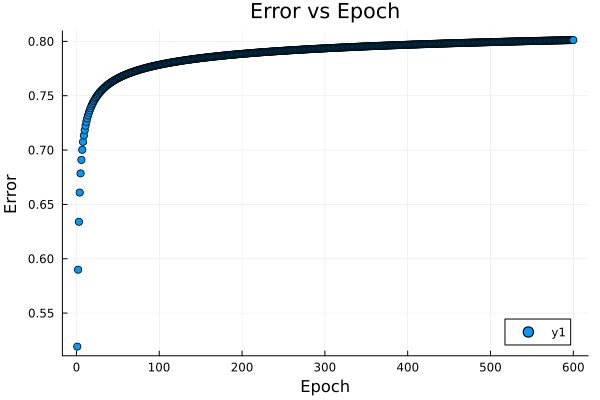

In [27]:
# Graficando el error
p = plot(errors, seriestype=:scatter, title="Error vs Epoch", xlabel="Epoch", ylabel="Error")


In [28]:
# Declaramos la funcion de hipotesis que va a correr todo para la unica neurona
function hypTest(bias::Float64, validation_hyp_df::DataFrame, row::Int64)
    global model
    global models

    y = 0.0
    # y = w1*x1 + w2*x2
    y = validation_hyp_df.Odometro_Norm[row]*models[model][1] + validation_hyp_df.Cantidad_Norm[row]*models[model][2]
    
    # Sumamos el bias
    y += bias

    # Funcion sigmoide
    y = 1/(1 + ℯ^(-y))
    
    # retornamos el resultado de la fila
    return y
 
end

hypTest (generic function with 1 method)

### Primero la validacion

In [29]:
validationResults = Vector{Int64}()

for row in 1:nrow(validation_hyp_df)
    if hypTest(bias, validation_hyp_df, row) > 0.5
        if validation_y[row] == 1
            push!(validationResults, 0)
        else
            push!(validationResults, 1)
        end
    elseif hypTest(bias, validation_hyp_df, row) < 0.5
        if validation_y[row] == 0
            push!(validationResults, 0)
        else
            push!(validationResults, 1)
        end
    end
end

count_ones = count(x -> x == 1, validationResults)
count_zeros = count(x -> x == 0, validationResults)

println("Datos validados correctamente: ", count_ones)
println("Datos validados INcorrectamente: ", count_zeros)



Datos validados correctamente: 60
Datos validados INcorrectamente: 3


In [30]:
porcentaje_exito_validacion = ((count_ones * 100) / (count_ones + count_zeros))
println("Porcentaje de exito en la validacion: % ", porcentaje_exito_validacion)

Porcentaje de exito en la validacion: % 95.23809523809524


### Ahora el test

In [31]:
testResults = Vector{Int64}()

for row in 1:nrow(test_hyp_df)
    if hypTest(bias, test_hyp_df, row) > 0.5
        if test_y[row] == 1
            push!(testResults, 0)
        else
            push!(testResults, 1)
        end
    elseif hypTest(bias, test_hyp_df, row) < 0.5
        if test_y[row] == 0
            push!(testResults, 0)
        else
            push!(testResults, 1)
        end
    end
end

count_ones = count(x -> x == 1, testResults)
count_zeros = count(x -> x == 0, testResults)

println("Datos predichos correctamente: ", count_ones)
println("Datos predichos INcorrectamente: ", count_zeros)



Datos predichos correctamente: 57
Datos predichos INcorrectamente: 7


In [32]:
porcentaje_exito_test = ((count_ones * 100) / (count_ones + count_zeros))
println("Porcentaje de exito en el test: % ", porcentaje_exito_test)

Porcentaje de exito en el test: % 89.0625


### Grafica heatmap

In [33]:
heatMapGraphic = [[0, 0],[0, 0]]
for i in 1:length(testResults)
    if testResults[i] == 0
        if test_y[i] == 0
            heatMapGraphic[1][1] += 1
        else
            heatMapGraphic[1][2] += 1
        end
    else
        if test_y[i] == 0
            heatMapGraphic[2][1] += 1
        else
            heatMapGraphic[2][2] += 1
        end
    end
end

heatMapGraphic

2-element Vector{Vector{Int64}}:
 [0, 7]
 [57, 0]